In [1]:
#!/usr/bin/env python3
import sys
srcdir = "/project/mchaisso_100/cmb-16/tsungyul/work/vntr/danbing-tk/script/"
sys.path.insert(0, srcdir)

In [2]:
import numpy as np
import pandas as pd
import vntrutils as vu
import utils
# import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# %load_ext autoreload
# %autoreload 2

In [3]:
from collections import defaultdict
import pickle
# import networkx as nx
# import pygraphviz
# import collections
import gc
import glob
# import warnings
import statsmodels.api as sm
# from statsmodels.stats.multitest import fdrcorrection as fdr
# from scipy import stats
import gzip
# from sklearn.decomposition import PCA
# from scipy.stats import chi2
# import re
# import json

In [4]:
matplotlib.rc('font', size=7)
matplotlib.rc('axes', titlesize=7)
matplotlib.rc('xtick', labelsize=5)
matplotlib.rc('ytick', labelsize=5)
%load_ext autoreload
%autoreload 2

In [12]:
def report_ground_truth_novel_kmers(fn):
    ch_s = [".", "=", "*"] # characters not interested
    reads = []
    ops = []
    opis = []
    ks = 21
    with gzip.open(fn, 'rt') as f:
        for line in f:
            vs = line.split()
            for chi, ch in enumerate(vs[4]):
                if ch not in ch_s:
                    print(vs[3])
                    print(f"{' '*(ks-1)}{vs[4]}")
                    reads.append(vs[3])
                    ops.append(vs[4])
                    opis.append(chi)
            for chi, ch in enumerate(vs[7]):
                if ch not in ch_s:
                    print(vs[6])
                    print(f"{' '*(ks-1)}{vs[7]}")
                    reads.append(vs[6])
                    ops.append(vs[7])
                    opis.append(chi)
    kmers = defaultdict(int)
    nr = 0
    for read, op, opi in zip(reads, ops, opis):
        RL = len(read)
        if op[opi-1] == "." or op[opi+1] == ".": continue # XXX boundary problem
        nr += 1
        # cre = f"{read[:opi+ks-1]}{op[opi]}{read[opi+ks:]}" # corrected read
        for si in range(opi, min(RL-ks,opi+ks-1)+1):
            assert si+ks<=RL
            kmn = read[si:si+ks]
            km = vu.string2CaKmer(kmn)
            kmers[km] += 1
    print (f"{nr} candidate reads")
    print(f"{len(kmers)} novel kmers")
    for km, ct in kmers.items():
        kmn = vu.decodeNumericString(km, ks)
        print(f"{km}\t{ct}\t{kmn}")
    return kmers
                    
gt_nkmers = report_ground_truth_novel_kmers("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.aln.gz") # ground truth novel kmers

AGGACGCCCGAGAAGACAGGCGGTGGCAGAGATCTTCAGAGAGAGAGATGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACACCTGAGAAGACAGG
                    =======G==========================================================================================================================
TCTGAAGATCTCCACCACCGCCTGTCTTCTCAGGTGTCCTCTCTCTGAAGATCTCCGCCACCGCCTGTCTTCTCGGGCGTCCTCTCTCTGAAGATCTCCGCCACCGCCTGTCTTCTCGGGCATCTCTCTCTCTGAAGATCTCTGCCACCG
                    ==========================================================================================================================C=======
TCAGAGAGAGGACGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACGCCCGAGAAGACAGGCGGTGGCAGAGATCTTCAGAGAGAGAGATGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACGCCCGAG
                    ==========================================================G=======================================================================
ACCGCCTGTCTTCTCGGGCGTCCTCTCTCTGAAGATCTCCGCCACCGCCTGTCTTCTCGGGCATCTCTCTCTCTGAAGATCTCTGCCACCGCCT

# Use reads simulated from `Art` + `.aln` generated by `danbing-tk.threadv1.20230901`

## TODO: read cigar strings

In [27]:
ks = 21

class nvk_t:
    def __init__(self):
        self.d = defaultdict(int) # novel kmers
        self.n = 0 # num of candidate reads
        
def _accum_novel_kmers_v3(nvk, read, cg, an, indel=False):
    if "=" not in an: return

    ni_s = [".", "=", "*","N"] # characters not interested
    # d_s = ["0","1","2","3"]
    # m_s = ["A","C","G","T"]
    
    rl = len(read)
    dti = 0
    chis = set()
    
    s_s = ["=", "*", "X", "D", "I"] # seperators
    cl = len(cg)
    i0 = 0
    i1 = 0
    ri = 0
    ntis = set()
    edi = 0 
    while i1 != cl:
        while cg[i1] not in s_s:
            i1 += 1
        sp = cg[i1]
        if sp == "=" or sp == "*":
            ri += int(cg[i0:i1])
            if sp == "*":
                
            i1 += 1
            i0 = i1
        elif sp == "X"
            ri += int(cg[i0:i1])
            
    for chi, ch in enumerate(cg):
        if ch in s_s:
            
        
        if ch not in ni_s:
            if ops[chi-1] != "=" and ops[chi+1] != "=": continue
            if ch in m_s:
                chis |= set(range(chi+dti,min(chi+dti+ks,rl)))
            elif ch in d_s:
                if indel:
                    chis |= set(range(chi+dti,min(chi+dti+ks-1,rl)))
                dti -= 1
            elif ch == "I":
                if indel:
                    chis |= set(range(chi+dti,min(chi+dti+ks,rl)))
        elif ch == "*" or ch == ".":
            chis -= set([chi+dti])
    if chis:
        nvk.n += 1
        for chi in chis:
            nvk.d[vu.string2CaKmer(read[chi:chi+ks])] += 1

In [70]:
def eval_novel_kmers_v3(fn, th=-1, indel=False):
    nvk = nvk_t()
    with gzip.open(fn, 'rt') as f:
        for line in f:
            vs = line.split()
            _accum_novel_kmers_v3(nvk, vs[3], vs[5], vs[6], indel=indel)
            _accum_novel_kmers_v3(nvk, vs[4], vs[7], vs[8], indel=indel)
    print (f"{nvk.n} candidate reads")
    
    vs = np.array(list(nvk.d.values()))
    utils.hist(vs[vs>th], dpi=300)
    mtp = defaultdict(int)
    for v in vs:
        mtp[v] += 1
    for k in sorted(mtp.keys()):
        print(k, mtp[k])
    print()
    
    nrep = 0
    maxn = 0
    ming = max(nvk.d.values())
    nbnoi = 0
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km in gt_nkmers:
            nrep += 1
            ming = min(ming, ct)
            print(f"{km}\t{ct}\t{kmn}")
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km not in gt_nkmers and ct >= ming:
            nbnoi += 1
            print(f"*{km}\t{ct}\t{kmn}")
            maxn = max(maxn, ct)

    ngt = len(gt_nkmers)
    nnoi = len(nvk.d) - nrep
    print(f"{nrep}/{ngt} ground truth novel kmers replicated, min replicated count = {ming}")
    print(f"{nnoi} noise kmers, {nbnoi} w/ ct >= {ming}, max count = {maxn}")

In [ ]:
# try on the easy errorenous case
eval_novel_kmers_v1("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.err.1bpindel.aln.gz", th=2)

## simply scan the whole read and check novel TR paths

In [46]:
def test():
    ntrkm = set()
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/input/loo_HG00171.175.ntr.kmers") as f:
        for line in f:
            if line[0] == ">": continue
            km = int(line.split()[0])
            ntrkm.add(km)
            km_ = vu.getRCkmer(km,21)
            assert km <= km_
    return ntrkm
ntrkm = test()

def test():
    trkm = set()
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/input/loo_HG00171.175.tr.kmers") as f:
        for line in f:
            if line[0] == ">": continue
            km = int(line.split()[0])
            trkm.add(km)
            km_ = vu.getRCkmer(km,21)
            assert km <= km_
    return trkm
trkm = test()

In [100]:
ks = 21

def _accum_novel_kmers_v4(nvk, read, cg, an):
    if "=" not in an: return
    if "X" not in cg and "D" not in cg and "I" not in cg: return
    
    nv = False
    nvk_ = defaultdict(int)
    kms = vu.read2kmers_noshift(read, ks)
    nk = kms.size
    ki = 0
    while ki != nk:
        while kms[ki] not in trkm: # find aln in TR
            ki += 1
            if ki == nk: break
        if ki == nk: break
        while kms[ki] in trkm: # find the start of a tract of novel kmers 
            ki += 1
            if ki == nk: break
        if ki == nk: break
        while kms[ki] not in trkm and kms[ki] not in ntrkm: # find the end of a tract of novel kmers
            nvk_[kms[ki]] += 1
            ki += 1
            if ki == nk: break
        if ki == nk: break # 3' unaligned
        
        # sanity check
        if nvk_:
            if kms[ki] in ntrkm: # novel path from TR to NTR
                print(f"! novel path from TR to NTR w {len(nvk_)} kmers")
            else:
                assert(kms[ki] in trkm)
                #print(f"novel path in TR w {len(nvk_)} kmers")
                for k, v in nvk_.items():
                    nvk.d[int(k)] += v
                nv = True
            nvk_ = defaultdict(int)
    if nv:
        nvk.n += 1

In [103]:
def eval_novel_kmers_v4(fn, th=-1):
    nvk = nvk_t()
    with gzip.open(fn, 'rt') as f:
        for line in f:
            vs = line.split()
            _accum_novel_kmers_v4(nvk, vs[3], vs[5], vs[6])
            _accum_novel_kmers_v4(nvk, vs[4], vs[7], vs[8])
    print (f"{nvk.n} candidate reads")
    
    vs = np.array(list(nvk.d.values()))
    utils.hist(vs[vs>th], "kmer occurrence", "# of kmers", dpi=300)
    mtp = defaultdict(int)
    for v in vs:
        mtp[v] += 1
    for k in sorted(mtp.keys()):
        print(k, mtp[k])
    print()
    
    nrep = 0
    maxn = 0
    ming = max(nvk.d.values())
    nbnoi = 0
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km in gt_nkmers:
            nrep += 1
            ming = min(ming, ct)
            print(f"{km}\t{ct}\t{kmn}")
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km not in gt_nkmers and ct >= ming:
            nbnoi += 1
            print(f"*{km}\t{ct}\t{kmn}")
            maxn = max(maxn, ct)

    ngt = len(gt_nkmers)
    nnoi = len(nvk.d) - nrep
    print(f"{nrep}/{ngt} ground truth novel kmers replicated, min replicated count = {ming}")
    print(f"{nnoi} noise kmers, {nbnoi} w/ ct >= {ming}, max count = {maxn}")

! novel path from TR to NTR w 21 kmers
! novel path from TR to NTR w 17 kmers
128 candidate reads


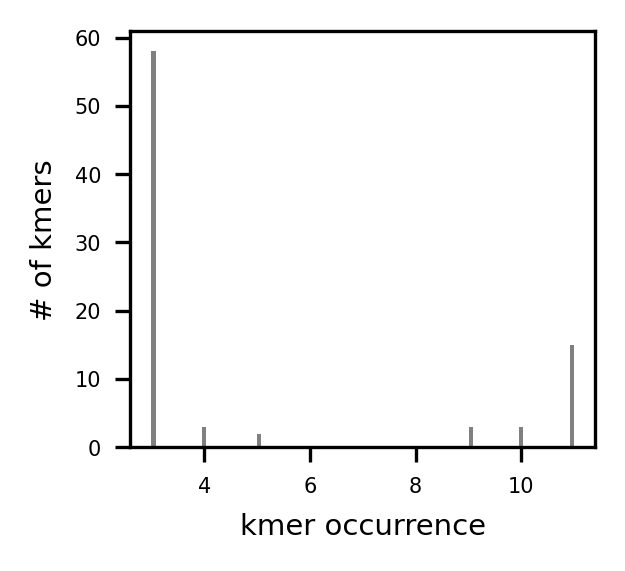

1 2270
2 175
3 58
4 3
5 2
9 3
10 3
11 15

1520557517732	11	CCGAGAAGACAGGCGGTGGCA
1684183559826	11	CGAGAAGACAGGCGGTGGCAG
2338687728200	11	GAGAAGACAGGCGGTGGCAGA
558657890594	11	AGAAGACAGGCGGTGGCAGAG
2234631562376	11	GAAGACAGGCGGTGGCAGAGA
142433227299	11	AAGACAGGCGGTGGCAGAGAT
569732909197	11	AGACAGGCGGTGGCAGAGATC
609320265197	11	AGATCTCTGCCACCGCCTGTC
152330066299	11	AAGATCTCTGCCACCGCCTGT
1278534099837	11	CAGGCGGTGGCAGAGATCTTC
716089888244	11	AGGCGGTGGCAGAGATCTTCA
2063964459365	11	CTGAAGATCTCTGCCACCGCC
2661345189704	11	GCGGTGGCAGAGATCTTCAGA
1849287736610	11	CGGTGGCAGAGATCTTCAGAG
2999104435336	11	GGTGGCAGAGATCTTCAGAGA
2052466794065	10	CTCTCTGAAGATCTCTGCCAC
3811651581844	10	TCTCTCTGAAGATCTCTGCCA
2052424523237	10	CTCTCTCTGAAGATCTCTGCC
2510642514056	9	GCAGAGATCTTCAGAGAGAGA
1246477034018	9	CAGAGATCTTCAGAGAGAGAG
587861624968	9	AGAGATCTTCAGAGAGAGAGA
21/21 ground truth novel kmers replicated, min replicated count = 9
2508 noise kmers, 0 w/ ct >= 9, max count = 0


In [104]:
eval_novel_kmers_v4("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/artv0/output/175.0901.aln.gz", th=2)

In [ ]:
eval_novel_kmers_v4("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/artv0/output/175.0901.aln.gz", th=2)